In [6]:
import pandas as pd
import numpy as np
from pathlib import Path
import os
import seaborn as sns
import matplotlib.pyplot as plt
from warnings import filterwarnings
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization,MaxPooling2D
from keras import models
from keras import layers
import tensorflow as tf
import os
import os.path
from pathlib import Path
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras import regularizers
from keras.optimizers import RMSprop,Adam
import glob
from PIL import Image

In [7]:
DATA_SET = ("Downloads/archive/Human Faces")

In [8]:
AI_images_path= Path("Downloads/archive/Human Faces/AI-Generated Images")
Human_images_Path = Path("Downloads/archive/Human Faces/Real Images")

AI_JPG_Path = list(AI_images_path.glob(r"*.jpg")) 
Human_JPG_Path = list(Human_images_Path.glob(r"*.jpg"))

In [9]:
#AI_JPG_Path

In [10]:
AI_Human_List = []

for AI_JPG in AI_JPG_Path:
    AI_Human_List.append(AI_JPG)
    
for Human_JPG in Human_JPG_Path:
    AI_Human_List.append(Human_JPG)


In [11]:
print(len(Human_JPG_Path))
print(Human_JPG_Path[:5])


5000
[WindowsPath('Downloads/archive/Human Faces/Real Images/000001.jpg'), WindowsPath('Downloads/archive/Human Faces/Real Images/000002.jpg'), WindowsPath('Downloads/archive/Human Faces/Real Images/000003.jpg'), WindowsPath('Downloads/archive/Human Faces/Real Images/000004.jpg'), WindowsPath('Downloads/archive/Human Faces/Real Images/000005.jpg')]


In [12]:

JPG_Labels = []

for path in AI_Human_List:
    path_lower = str(path).lower()  # convert full path to lowercase

    if "ai" in path_lower:
        JPG_Labels.append("AI")
    elif "human" in path_lower:
        JPG_Labels.append("HUMAN")
    else:
        JPG_Labels.append("UNKNOWN")  # fallback

print("Unique labels:", set(JPG_Labels))
print("AI COUNTING:", JPG_Labels.count("AI"))
print("Human COUNTING:", JPG_Labels.count("HUMAN"))


Unique labels: {'HUMAN', 'AI'}
AI COUNTING: 4630
Human COUNTING: 5000


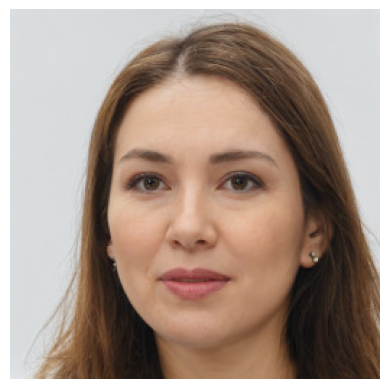

In [15]:
from PIL import Image
import matplotlib.pyplot as plt

# Choose an index of the image you want to display
index = 0  # for the first image

img_path = AI_Human_List[index]

# Open and show the image
img = Image.open(img_path)
plt.imshow(img)
plt.axis('off')  # hide axes
plt.show()


In [16]:
df["image_path"] = df["image_path"].astype(str)


NameError: name 'df' is not defined

In [17]:
# Create DataFrame
df = pd.DataFrame({
    "image_path": AI_Human_List,
    "label_str": JPG_Labels
})

#  FIX: convert Path objects to strings
df["image_path"] = df["image_path"].astype(str)

# Numeric labels
df["label"] = df["label_str"].map({"AI": 0, "HUMAN": 1})



# Check counts
print(df["label_str"].value_counts())
print(df.head())


label_str
HUMAN    5000
AI       4630
Name: count, dtype: int64
                                          image_path label_str  label
0  Downloads\archive\Human Faces\AI-Generated Ima...        AI      0
1  Downloads\archive\Human Faces\AI-Generated Ima...        AI      0
2  Downloads\archive\Human Faces\AI-Generated Ima...        AI      0
3  Downloads\archive\Human Faces\AI-Generated Ima...        AI      0
4  Downloads\archive\Human Faces\AI-Generated Ima...        AI      0


In [18]:

# Filter rows where label_str is "HUMAN"
human_df = df[df["label_str"] == "HUMAN"]

# Or, using numeric label
# human_df = df[df["label"] == 1]

# Check
print("Number of human images:", len(human_df))
print(human_df.head())

Number of human images: 5000
                                             image_path label_str  label
4630  Downloads\archive\Human Faces\Real Images\0000...     HUMAN      1
4631  Downloads\archive\Human Faces\Real Images\0000...     HUMAN      1
4632  Downloads\archive\Human Faces\Real Images\0000...     HUMAN      1
4633  Downloads\archive\Human Faces\Real Images\0000...     HUMAN      1
4634  Downloads\archive\Human Faces\Real Images\0000...     HUMAN      1


In [19]:
# 4️ Stratified train/validation split
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df["label_str"],
    random_state=42
)

print("Train counts:\n", train_df["label_str"].value_counts())
print("Validation counts:\n", val_df["label_str"].value_counts())

Train counts:
 label_str
HUMAN    4000
AI       3704
Name: count, dtype: int64
Validation counts:
 label_str
HUMAN    1000
AI        926
Name: count, dtype: int64


In [20]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col="image_path",
    y_col="label_str",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=True
)

val_gen = val_datagen.flow_from_dataframe(
    val_df,
    x_col="image_path",
    y_col="label_str",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False
)



Found 7704 validated image filenames belonging to 2 classes.
Found 1926 validated image filenames belonging to 2 classes.


In [21]:
IMG_SIZE = (224, 224)

In [22]:

from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Input(shape=(*IMG_SIZE, 3)),  
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
# 6️  Train model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    steps_per_epoch=25  
)


Epoch 1/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.8625 - loss: 0.4002 - val_accuracy: 0.9912 - val_loss: 0.0232
Epoch 2/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.9725 - loss: 0.0621 - val_accuracy: 0.9964 - val_loss: 0.0129
Epoch 3/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.9925 - loss: 0.0193 - val_accuracy: 0.9995 - val_loss: 0.0036
Epoch 4/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.9912 - loss: 0.0145 - val_accuracy: 0.9958 - val_loss: 0.0111
Epoch 5/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.9975 - loss: 0.0049 - val_accuracy: 0.9990 - val_loss: 0.0022
Epoch 6/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 1.0000 - loss: 8.3868e-04 - val_accuracy: 0.9995 - val_loss: 0.0019
Epoch 7/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.9975 - loss: 0.0068 - val_accuracy: 0.9984 - val_loss: 0.0048
Epoch 8/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.9975 - loss: 0.0061 - val_accuracy: 1.0000 - val_l

C:\Users\manas\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


25/25 ━━━━━━━━━━━━━━━━━━━━ 24s 956ms/step - accuracy: 0.9980 - loss: 0.0055 - val_accuracy: 0.9990 - val_loss: 0.0022
Epoch 11/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.9975 - loss: 0.0074 - val_accuracy: 0.9990 - val_loss: 0.0020
Epoch 12/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.9975 - loss: 0.0027 - val_accuracy: 0.9995 - val_loss: 0.0012
Epoch 13/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.9912 - loss: 0.0197 - val_accuracy: 0.9995 - val_loss: 0.0029
Epoch 14/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 1.0000 - val_loss: 1.9655e-04
Epoch 15/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 1.0000 - loss: 3.6870e-04 - val_accuracy: 1.0000 - val_loss: 7.3524e-04


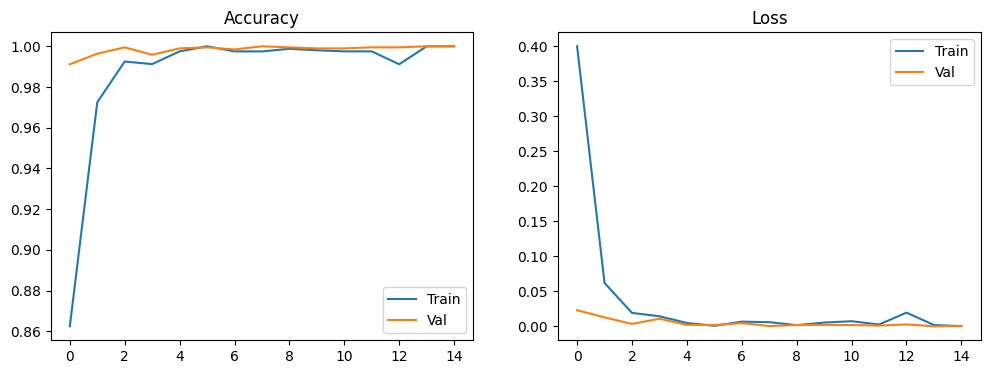

In [25]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Train")
plt.plot(history.history["val_accuracy"], label="Val")
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Val")
plt.title("Loss")
plt.legend()

plt.show()


In [26]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

# True labels (already numpy)
y_true = val_gen.classes
# Predict probabilities
y_pred_prob = model.predict(val_gen)

# Convert to 0/1
y_pred = (y_pred_prob > 0.5).astype(int).ravel()


61/61 ━━━━━━━━━━━━━━━━━━━━ 11s 186ms/step


In [27]:
cm = confusion_matrix(y_true, y_pred)
print(cm)

[[ 926    0]
 [   0 1000]]


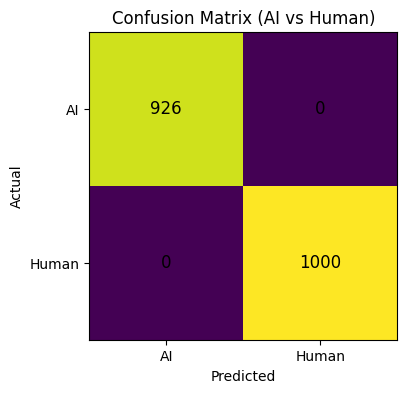

In [31]:
plt.figure(figsize=(5,4))
plt.imshow(cm)

plt.xticks([0,1], ["AI", "Human"])
plt.yticks([0,1], ["AI", "Human"])

plt.xlabel("Predicted")
plt.ylabel("Actual")

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j],
                 ha="center", va="center", color="black", fontsize=12)

plt.title("Confusion Matrix (AI vs Human)")
plt.show()


In [32]:
model.save("Human_face_analysisCNN.h5")